![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Calculate z-aggregates in quantiles (classes) of x and y
</b>
</span>

---
**Notebook version**: `1` (23 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- By default, x and y are binned into 10 classes and the aggregate of z (mean, median, min, max, counts) is shown in each of the resulting 100 classes (10*10).

</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.analyses.quantilexyaggz import QuantileXYAggZ
from diive.core.plotting.heatmap_xyz import HeatmapPivotXYZ
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.71.6


In [2]:
help(QuantileXYAggZ)

Help on class QuantileXYAggZ in module diive.pkgs.analyses.quantilexyaggz:

class QuantileXYAggZ(builtins.object)
 |  QuantileXYAggZ(x: pandas.core.series.Series, y: pandas.core.series.Series, z: pandas.core.series.Series, n_quantiles: int = 10, min_n_vals_per_bin: int = 1, binagg_z: Literal['mean', 'min', 'max', 'median', 'count'] = 'mean')
 |  
 |  Calculate z-aggregates in quantiles (classes) of x and y
 |  
 |  By default, x and y are binned into 10 classes (n_quantiles: int = 10) and
 |  the mean of z is shown in each of the resulting 100 classes (10*10).
 |  
 |  The result is a pivoted dataframe and its longform.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x: pandas.core.series.Series, y: pandas.core.series.Series, z: pandas.core.series.Series, n_quantiles: int = 10, min_n_vals_per_bin: int = 1, binagg_z: Literal['mean', 'min', 'max', 'median', 'count'] = 'mean')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  run(self)
 |  
 |  -------

</br>

# **Load example data**

In [3]:
df = load_exampledata_parquet()
df.head()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.055 seconds). Detected time resolution of <30 * Minutes> / 30T 


,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_CUT_REF_fqc,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,GPP_DT_CUT_REF_SD,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,...,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_fqc,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,0.290134,0.509709,-0.082120,0.704570,1.0,0.0,0.0,0.0,0.0,13.092806,NaN,194.913214,1.376122,NaN,1.537436,...,2.300025,1.251884,1.907757,1.613003,0.509600,0.0,0.0,31.933333,34.97662,-1.618,-1.618,0.0,0.287644,1.339,1.339
2013-01-01 00:45:00,0.290130,0.511877,-0.083807,0.707522,1.0,0.0,0.0,0.0,0.0,13.092806,NaN,193.567693,1.376122,NaN,1.537436,...,2.302977,1.241100,1.913934,1.616019,0.512473,0.0,0.0,32.600000,34.97673,-1.630,-1.630,0.0,0.287644,1.337,1.337
2013-01-01 01:15:00,0.289530,0.513692,-0.085813,0.710022,1.0,0.0,0.0,0.0,0.0,13.065880,NaN,193.135202,1.376122,NaN,1.537436,...,2.305477,1.230092,1.919791,1.618733,0.515297,0.0,0.0,38.866667,34.97131,-1.644,-1.644,0.0,0.287644,1.335,1.335
2013-01-01 01:45:00,0.289526,1.354227,-0.087657,1.770620,0.0,0.0,0.0,0.0,0.0,13.065880,NaN,192.082736,0.537565,0.537565,1.537436,...,2.308185,1.219232,1.925787,1.621581,0.518213,0.0,0.0,37.766667,34.97497,-1.657,-1.657,0.0,0.287644,1.332,1.332
2013-01-01 02:15:00,0.376985,0.545335,-0.079582,0.796802,1.0,0.0,0.0,0.0,0.0,16.995263,NaN,192.677177,1.544471,NaN,1.709463,...,2.561882,1.346570,2.105211,1.790283,0.578416,0.0,0.0,39.533333,34.96657,-0.567,-0.567,1.0,0.287644,3.545,3.545


## Make subset

In [4]:
# Make subset of three required columns
vpd_col = 'VPD_f'
ta_col = 'Tair_f'
swin_col = 'Rg_f'
df = df[[vpd_col, ta_col, swin_col]].copy()

In [5]:
# Use data May and Sep
df = df.loc[(df.index.month >= 5) & (df.index.month <= 9)].copy()

In [6]:
# Use daytime data 
daytime_locs = (df[swin_col] > 0)
df = df[daytime_locs].copy()
df = df.dropna()

In [7]:
df

,VPD_f,Tair_f,Rg_f
TIMESTAMP_MIDDLE,,,
2013-05-01 05:15:00,2.843000,7.667000,2.912000
2013-05-01 05:45:00,1.425000,5.967000,21.093000
2013-05-01 06:15:00,1.460000,6.167000,50.277000
2013-05-01 06:45:00,1.587000,6.700000,96.650000
2013-05-01 07:15:00,1.586000,6.900000,162.190000
...,...,...,...
2022-09-30 16:15:00,0.155508,3.216667,111.234822
2022-09-30 16:45:00,0.145530,3.170000,77.094392
2022-09-30 17:15:00,0.121007,3.203333,56.054191


</br>

# (1) **Calculate mean of z in 10 quantile classes of x and y**

In [8]:
q = QuantileXYAggZ(
    x=df[swin_col],
    y=df[ta_col],
    z=df[vpd_col],
    n_quantiles=10,
    min_n_vals_per_bin=3,
    binagg_z='mean'
)
q.run()
pivotdf = q.pivotdf.copy()
pivotdf

BIN_Rg_f,0,10,20,30,40,50,60,70,80,90
BIN_Tair_f,,,,,,,,,,
0,0.738024,0.882304,0.907605,0.783157,0.882982,1.210850,1.484718,1.906717,2.125012,2.569838
10,1.109056,1.247967,1.250752,1.205220,1.362104,1.741092,2.281084,2.827535,3.221663,3.404702
20,1.359261,1.609307,1.517439,1.466339,1.760114,2.230850,2.803947,3.519976,3.936588,4.287594
30,1.803608,1.966314,1.899253,1.815352,2.243765,3.295723,3.494338,4.207598,4.818142,5.080772
40,2.191479,2.617572,2.407730,2.455839,2.951032,3.803166,4.380595,4.944196,5.332919,6.178703
50,3.147066,3.443446,3.602164,3.537311,3.662920,4.668225,5.444466,6.001370,6.345781,7.025563
60,4.698862,5.103392,5.021594,5.149914,5.501500,6.085669,6.519011,7.157835,7.794133,8.057699
70,6.514295,6.907278,7.306493,7.352748,7.474087,8.048795,8.563876,8.860651,9.405354,9.825718
80,9.090345,9.430673,9.720302,9.983889,10.115966,10.705979,11.236662,11.251579,12.075461,12.163915


</br>

## Plot

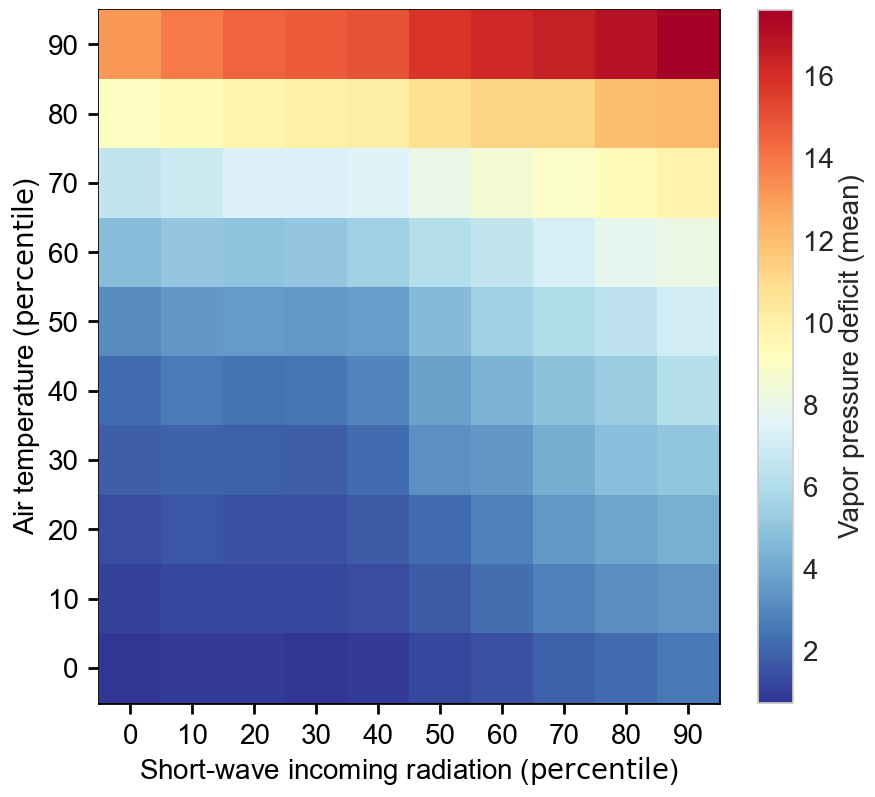

In [9]:
hm = HeatmapPivotXYZ(pivotdf=pivotdf)
hm.plot(
    cb_digits_after_comma=0,
    xlabel=r'Short-wave incoming radiation ($\mathrm{percentile}$)',
    ylabel=r'Air temperature ($\mathrm{percentile}$)',
    zlabel=r'Vapor pressure deficit (mean)'
)

</br>

# (2) **Calculate counts of z in 100 quantile classes of x and y**

In [10]:
q = QuantileXYAggZ(
    x=df[swin_col],
    y=df[ta_col],
    z=df[vpd_col],
    n_quantiles=100,
    min_n_vals_per_bin=3,
    binagg_z='count'
)
q.run()
pivotdf = q.pivotdf.copy()
pivotdf

BIN_Rg_f,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
BIN_Tair_f,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.0,9.0,8.0,7.0,11.0,6.0,8.0,11.0,8.0,7.0,8.0,8.0,8.0,18.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,3.0,4.0,8.0,11.0,11.0,12.0,8.0,9.0,7.0,6.0,4.0,7.0,8.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,6.0,8.0,NaN,6.0,6.0,7.0,6.0,6.0,10.0,6.0,7.0,10.0,13.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.0,9.0,7.0,10.0,8.0,8.0,8.0,12.0,5.0,6.0,9.0,6.0,8.0,8.0,7.0,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN
4,8.0,7.0,NaN,6.0,6.0,5.0,8.0,7.0,7.0,5.0,4.0,7.0,5.0,9.0,8.0,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,10.0,12.0,12.0,19.0,9.0,15.0,12.0,9.0,12.0,13.0,20.0,17.0,14.0,11.0,10.0
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,11.0,12.0,13.0,9.0,16.0,22.0,18.0,8.0,16.0,5.0,21.0,13.0,24.0,8.0,5.0
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,17.0,10.0,13.0,15.0,14.0,15.0,10.0,16.0,21.0,19.0,12.0,10.0,11.0,6.0


</br>

## Plot
- In this case there are many classes (100*100), therefore it is recommended to manually define `tickpos` and `ticklabels`.

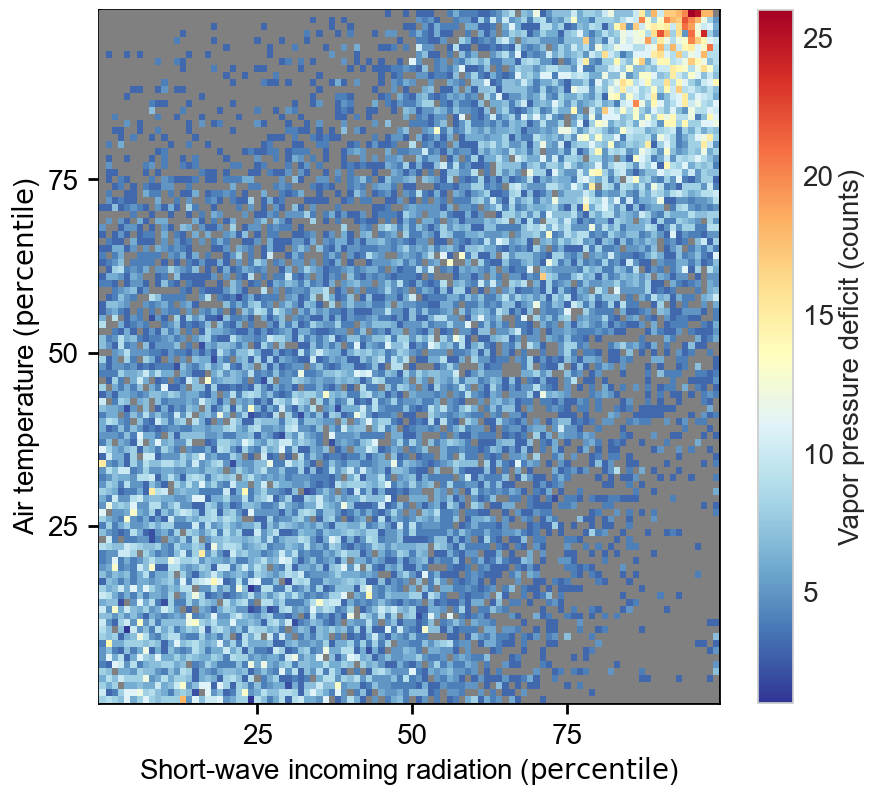

In [11]:
hm = HeatmapPivotXYZ(pivotdf=pivotdf)
hm.plot(
    cb_digits_after_comma=0,
    xlabel=r'Short-wave incoming radiation ($\mathrm{percentile}$)',
    ylabel=r'Air temperature ($\mathrm{percentile}$)',
    zlabel=r'Vapor pressure deficit (counts)',
    tickpos=[25, 50, 75],
    ticklabels=['25', '50', '75']
)

</br>

# **End of notebook**

In [12]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-03-23 00:36:01
